In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
import keras
import tensorflow
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [1]:
from google.colab import files  
uploaded = files.upload()

Saving NIFTY50 - NIFTY50.csv to NIFTY50 - NIFTY50.csv


In [4]:
import io
Data=pd.read_csv(io.BytesIO(uploaded['NIFTY50 - NIFTY50.csv']))

In [5]:
cols= list(Data)[1:5]
stock_prices = Data[cols].astype(float)

# Normalizing Data

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(stock_prices)
stock_prices_scaled = scaler.transform(stock_prices)
print('df_for_training_scaled shape == {}.'.format(stock_prices_scaled.shape))

df_for_training_scaled shape == (3326, 4).


# Test Train Data Split

In [8]:
train_size = int(len(stock_prices_scaled) * 0.66)
test_size = len(stock_prices_scaled) - train_size
train, test = stock_prices_scaled[0:train_size,:], stock_prices_scaled[train_size:len(stock_prices_scaled),:]


# Input Label Splitter:

In [26]:
train_inputs = []
train_closing_labels=[]

In [27]:
n_future = 1   # Number of days we want to predict into the future
n_past = 14   # Number of past days we want to use to predict the future
for i in range(n_past, len(train) - n_future +1):
    train_inputs.append(train[i - n_past:i, 0:train.shape[1]])
    #train_opening_labels.append(train[i + n_future - 1:i + n_future, 0])
    train_closing_labels.append(train[i + n_future - 1:i + n_future, 1])
train_inputs, train_closing_labels = np.array(train_inputs), np.array(train_closing_labels)


In [28]:
print('train_input shape == {}.'.format(train_inputs.shape))
print('train_closing shape == {}.'.format(train_closing_labels.shape))

train_input shape == (2181, 14, 4).
train_closing shape == (2181, 1).


# Training The Data using Stacked LSTM

In [30]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(train_inputs.shape[1], train_inputs.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
#model.add(Activation('softmax'))
#model.add(Dense(32))
model.add(Dense(train_closing_labels.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 14, 64)            17664     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


# Predicting the opening price

In [13]:
history = model.fit(train_inputs, train_closing_labels, epochs = 100, validation_data = (train_inputs, train_closing_labels), batch_size = 32, verbose=1)

Epoch 1/100
69/69 [==============================] - 5s 28ms/step - loss: 0.3234 - val_loss: 0.0062
Epoch 2/100
69/69 [==============================] - 1s 19ms/step - loss: 0.0311 - val_loss: 0.0032
Epoch 3/100
69/69 [==============================] - 1s 19ms/step - loss: 0.0248 - val_loss: 0.0037
Epoch 4/100
69/69 [==============================] - 1s 22ms/step - loss: 0.0179 - val_loss: 0.0066
Epoch 5/100
69/69 [==============================] - 1s 19ms/step - loss: 0.0182 - val_loss: 0.0057
Epoch 6/100
69/69 [==============================] - 1s 20ms/step - loss: 0.0181 - val_loss: 0.0023
Epoch 7/100
69/69 [==============================] - 1s 19ms/step - loss: 0.0149 - val_loss: 0.0021
Epoch 8/100
69/69 [==============================] - 1s 20ms/step - loss: 0.0164 - val_loss: 0.0022
Epoch 9/100
69/69 [==============================] - 1s 19ms/step - loss: 0.0135 - val_loss: 0.0030
Epoch 10/100
69/69 [==============================] - 1s 20ms/step - loss: 0.0167 - val_loss: 0.0018

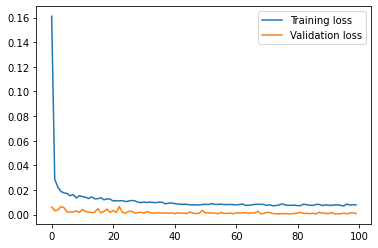

In [14]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


# Checking the predictions of training data

In [32]:
training_data_prediction= model.predict(train_inputs) 
training_data_prediction

array([[0.14453669],
       [0.14136626],
       [0.13884105],
       ...,
       [0.03088907],
       [0.03094719],
       [0.0309309 ]], dtype=float32)

In [31]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
forecast_copies_1 = np.repeat(training_data_prediction, train.shape[1], axis=-1)
predicted_train = scaler.inverse_transform(forecast_copies_1)[:,0]
predicted_train

array([5139.389 , 5080.8823, 5154.79  , ..., 8723.784 , 8727.333 ,
       8700.963 ], dtype=float32)

In [17]:
Train_data=Data[n_past:train_size]
Train_data['Date']=pd.to_datetime(Train_data['Date'])
training_forecast = pd.DataFrame( {'Date':Train_data['Date'],'Close':Train_data['Close'],'Forecast':predicted_train})
train_graph=training_forecast.set_index('Date')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
train_graph

,Close,Forecast
Date,,
2007-10-08,5085.100098,5139.389160
2007-10-09,5327.250000,5080.882324
2007-10-10,5441.450195,5154.790039
2007-10-11,5524.850098,5345.670410
2007-10-12,5428.250000,5443.497070
...,...,...
2016-09-15,8742.549805,8625.427734
2016-09-16,8779.849609,8662.113281
2016-09-19,8808.400391,8723.784180


# Plotting the actual close price and predicted close price of training sample

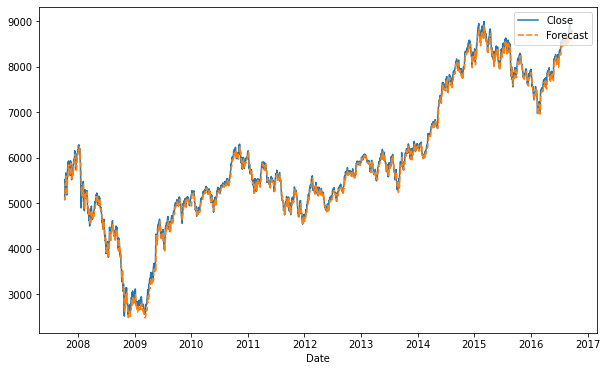

In [18]:
line,ax = plt.subplots(figsize=(10,6))
ax = sns.lineplot(data=train_graph)
ax.legend (loc="upper right")

# Finding the training error, bias

In [20]:
import math
trainScore = math.sqrt(mean_squared_error(train_graph['Close'], train_graph['Forecast']))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 99.89 RMSE


# Checking the model on test data

In [21]:
test_inputs=[]
for i in range(n_past, len(test) - n_future +1):
    test_inputs.append(test[i - n_past:i, 0:train.shape[1]])
test_inputs=np.array(test_inputs)

In [22]:
testing_data_prediction= model.predict(test_inputs) 
forecast_copies_2 = np.repeat(testing_data_prediction, test.shape[1], axis=-1)
predicted_test = scaler.inverse_transform(forecast_copies_2)[:,0]

In [23]:
Test_data=Data[train_size+n_past:len(stock_prices_scaled)]
Test_data['Date']=pd.to_datetime(Test_data['Date'])
testing_forecast = pd.DataFrame( {'Date':Test_data['Date'],'Close':Test_data['Close'],'Forecast':predicted_test})
test_graph=testing_forecast.set_index('Date')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


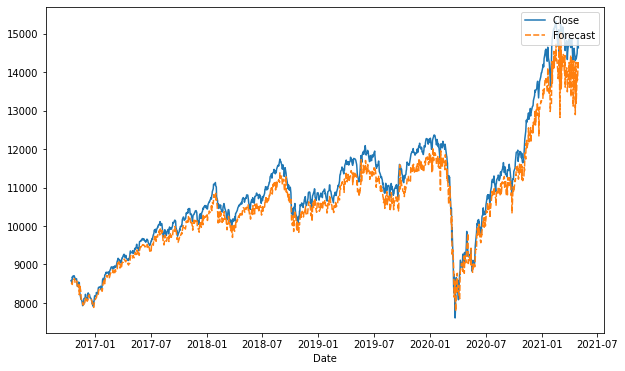

In [24]:
line,ax = plt.subplots(figsize=(10,6))
ax = sns.lineplot(data=test_graph)
ax.legend (loc="upper right")

In [25]:
import math
testScore = math.sqrt(mean_squared_error(test_graph['Close'], test_graph['Forecast']))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 390.02 RMSE
